# Background

[Redacted] is a fitness club chain in Canada.
[Redacted] offers a range of fitness classes in two capacities - 25 and 15. 
Some classes are always fully booked. Fully booked classes often have a low attendance rate.
[Redacted] wants to increase the number of spaces available for classes. They want to do this by predicting whether the member will attend the class or not. If they can predict a member will not attend the class, they can make another space
available.


# Data Introduction and Validation:

We will start be an introductory examination of our data and check to see whether the data falls within the ruleset on our data definitions [table](https://s3.amazonaws.com/talent-assets.datacamp.com/Practical+-+DSA+-+Fitness+Class+-+2212.pdf) If any columns do not match, we will adjust accordingly.

In [2]:
#Import pandas
import pandas as pd
#Read in the csv
gzdf = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/fitness_class_2212.csv')
#Initial look:
print(gzdf.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB
None


Our dataset consists of 1500 rows and 8 columns. We immediately see 20 NA values in the weight column. Let's start by fixing those values. Per the data definitions table, we will replace missing weight values with the average weight.

In [3]:
#Get the mean weight
meanWeight = gzdf['weight'].mean()
#Fill nulls with meanWeight
gzdf['weight'].fillna(value=meanWeight, inplace = True)
#Double check to confirm we do not have any other missing values:
print(gzdf.shape, '\n', gzdf.isna().sum())


(1500, 8) 
 booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64


After taking care of missing values, let's double check to make sure that our data follows the rules of the data definitions table:

In [4]:
print(gzdf.describe(include='all'))

         booking_id  months_as_member       weight  ...  time category     attended
count   1500.000000       1500.000000  1500.000000  ...  1500     1500  1500.000000
unique          NaN               NaN          NaN  ...     2        6          NaN
top             NaN               NaN          NaN  ...    AM     HIIT          NaN
freq            NaN               NaN          NaN  ...  1141      667          NaN
mean     750.500000         15.628667    82.610378  ...   NaN      NaN     0.302667
std      433.157015         12.926543    12.680411  ...   NaN      NaN     0.459565
min        1.000000          1.000000    55.410000  ...   NaN      NaN     0.000000
25%      375.750000          8.000000    73.562500  ...   NaN      NaN     0.000000
50%      750.500000         12.000000    81.035000  ...   NaN      NaN     0.000000
75%     1125.250000         19.000000    89.382500  ...   NaN      NaN     1.000000
max     1500.000000        148.000000   170.520000  ...   NaN      NaN     1

In [5]:
print(gzdf['days_before'].drop_duplicates())

0             8
1             2
2            14
3            10
6             6
10            4
17            9
20           12
60            5
70            3
72            7
79           13
93      12 days
109          20
116           1
124          15
189      6 days
203          11
236     13 days
238      3 days
275          16
313      1 days
380      7 days
398      8 days
462     10 days
477     14 days
606          17
803      5 days
852      2 days
874      4 days
1366         29
Name: days_before, dtype: object


No months are less than 1, no weights are less than 40 kg, and all row counts are 1500, matching the shape we printed earlier. When we focus on specific columns however, we notice some discrepancies. Starting with the "days_before" column, we notice that some of our day counts include the string "days" afterward. Additionally, this column would be best as an integer for later analysis. We will drop the strings and convert to an integer.

In [6]:
# We see text appear. This column would also be best represented as an integer for later analysis. Let's fix this:
gzdf['days_before'] = gzdf['days_before'].str.extract('(\d+)', expand=False)
gzdf['days_before'] = gzdf['days_before'].astype('int')
print(gzdf['days_before'].min())

1


After doing this, we note that minimum days_before is now 1. This matches our data rules. Looking at the day_of_week column, some days are written in full length, some have periods after abbreviations. We will standardize format to three-letter abbreviations without periods.

In [7]:
print(gzdf['day_of_week'].drop_duplicates())

0           Wed
1           Mon
2           Sun
3           Fri
4           Thu
6     Wednesday
8          Fri.
10          Tue
20          Sat
61       Monday
Name: day_of_week, dtype: object


In [8]:
#Run string replacements:
gzdf['day_of_week'] = gzdf['day_of_week'].str.replace('Wednesday', 'Wed')
gzdf['day_of_week'] = gzdf['day_of_week'].str.replace('Monday', 'Mon')
gzdf['day_of_week'] = gzdf['day_of_week'].str.replace('.', '')
#Check results:
print(gzdf['day_of_week'].drop_duplicates())


0     Wed
1     Mon
2     Sun
3     Fri
4     Thu
10    Tue
20    Sat
Name: day_of_week, dtype: object


In [9]:
print(gzdf['time'].drop_duplicates())

0    PM
1    AM
Name: time, dtype: object


For the category column, even though there are no NAs, there is a dash which doesn't match the data rules. We will replace with "unknown."

In [11]:
gzdf['category'] = gzdf['category'].str.replace('-', 'unknown')
print(gzdf['category'].drop_duplicates())

0     Strength
1         HIIT
3      Cycling
17        Yoga
55     unknown
63        Aqua
Name: category, dtype: object


In [12]:
print(gzdf['attended'].drop_duplicates())

0    0
8    1
Name: attended, dtype: int64


We will also transform the attended column. As a binary variable that represents a true (attended) or false (absentee), we will reframe this data for better visualization and analysis.

In [13]:
gzdf['attended'] = gzdf['attended'].astype('bool')

After these transformations, the entirety of the data now matches the ruleset. We will need to perform further transformations for modeling, but this works for now. We can re-examine the data summary now:

In [14]:
print(gzdf.info())
print(gzdf.describe(include = 'all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1500 non-null   float64
 3   days_before       1500 non-null   int64  
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 83.6+ KB
None
         booking_id  months_as_member       weight  ...  time category attended
count   1500.000000       1500.000000  1500.000000  ...  1500     1500     1500
unique          NaN               NaN          NaN  ...     2        6        2
top             NaN               NaN          NaN  ...    AM     HIIT    False
freq            NaN        

# Data Exploration

All of our data now matches the rules of the data definitions table. Let's look at our data visually now. We will start by understanding just how much potential [Redacted] has to increase class size by opening additional reservation spots.

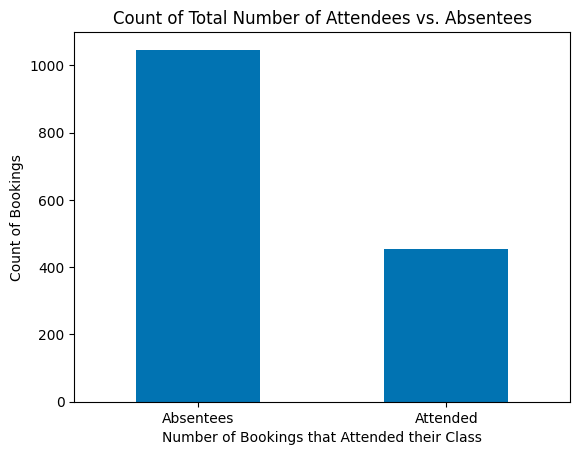

In [15]:
#Import viz tools
import matplotlib.pyplot as plt
import seaborn as sns

#Set a readable and inclusive color scheme:
sns.set_palette("colorblind")

#Let's see a general districution
gzdf['attended'].value_counts().plot(kind='bar', title='Count of Total Number of Attendees vs. Absentees')
plt.xticks([0,1], labels=['Absentees','Attended'], rotation='horizontal')
plt.xlabel('Number of Bookings that Attended their Class')
plt.ylabel('Count of Bookings')
plt.show()

In [16]:
print(gzdf['attended'].sum(), 'bookings attended their class out of', gzdf['attended'].count(), "total bookings, yielding an attendance rate of", round((gzdf['attended'].sum()/gzdf['attended'].count()*100), 2))
print()

454 bookings attended their class out of 1500 total bookings, yielding an attendance rate of 30.27



Less than a third of [Redacted]'s bookings actually attend the class. More precisely, only 454 bookings attended their class out 1500 total bookings, yielding an attendance-to-booking rate of 30.27%.

Now that we understand just how big the absentee pool is, let's see if we can understand [Redacted]'s clientelle a little more.

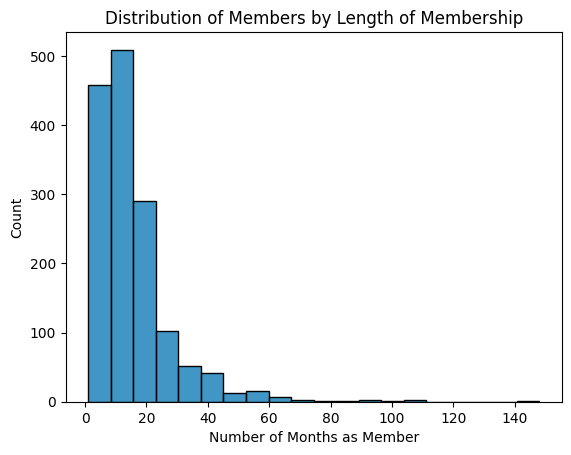

In [17]:
sns.histplot(gzdf['months_as_member'], bins = 20)
plt.title('Distribution of Members by Length of Membership')
plt.xlabel('Number of Months as Member')
plt.show()

Most of [Redacted]'s members have been a member for 1-2 years. Retention for memberships longer than two years drops precipitously. (Although, there are a few committed clients who have been members for 5+ years!)

Let's see if we can understand how these clients interact with [Redacted]'s classes and whether there is a relationship between attendees and the length of time they have been a member of the gym.

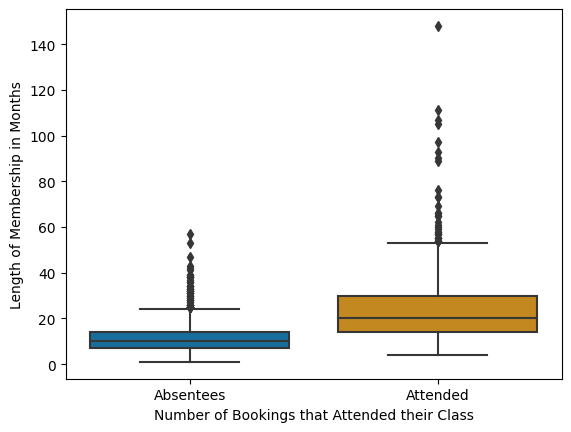

In [18]:
sns.boxplot(data= gzdf, x='attended', y='months_as_member')
plt.xticks([0,1], labels=['Absentees','Attended'])
plt.xlabel('Number of Bookings that Attended their Class')
plt.ylabel('Length of Membership in Months')
plt.show()

Typically, bookings that do not attend their class have not been members of [Redacted] for as long as those that do attend their bookings. The median attendee has been a member for around 2 years, while the median absentee has been a member for closer to a year. The longer a client has been a member of [Redacted], it seems they are more likely to attend the class they book. Now that we see there appears to be some factors that we can use to predict whether someone will attend their booking, let's see if we can build a model that will assist [Redacted] and allow them to accept more bookings per class based on the predicted absentees.

# Data Preparation

We will use look at a few different models to see which model is most predictive. As attendance can be classified as a binary choice, we will look at use a Logistic Regression model as a simple baseline model that will allow us to compare other more complex models. We will use classification methodologies for these more complex models - both a K-Nearest Neighbors models and a Random Forest Classifier. There are a few more preparatory steps we need to take before we begin modeling.

### Getting appropriate libraries and functions

In [19]:
#Importing relevant libraries and function
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from pandas.api.types import CategoricalDtype

### Data Transformations for Modeling

In [20]:
#Now, let's make the relevant columns categorical so they can be analyzed as numeric values in a numpy array.
dayCats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_cat_type = CategoricalDtype(categories=dayCats, ordered=True)
gzdf['day_of_week'] = gzdf['day_of_week'].astype(day_cat_type)

timeCats = ['AM', 'PM']
time_cat_type = CategoricalDtype(categories=timeCats, ordered=True)
gzdf['time'] = gzdf['time'].astype(time_cat_type)

catCats = ['Aqua','Cycling','HIIT', 'Strength','Yoga', 'unknown']
cat_cat_type = CategoricalDtype(categories=catCats, ordered=True)
gzdf['category'] = gzdf['category'].astype(cat_cat_type)

In [21]:
#Now let's get dummies_variables for our categorical data:
gzdf = pd.get_dummies(gzdf)

#Now, let's convert the weight column to an int to ease computational burden
gzdf['weight'] = round(gzdf['weight'])
gzdf['weight'] = gzdf['weight'].astype(int)

#Let's also look at our correlation coefficients to do some feature selection:
gzdf.corrwith(gzdf['attended'], method = 'pearson')

booking_id               0.026693
months_as_member         0.485526
weight                  -0.282782
days_before              0.024068
attended                 1.000000
day_of_week_Monday            NaN
day_of_week_Tuesday           NaN
day_of_week_Wednesday         NaN
day_of_week_Thursday          NaN
day_of_week_Friday            NaN
day_of_week_Saturday          NaN
day_of_week_Sunday            NaN
time_AM                  0.049850
time_PM                 -0.049850
category_Aqua            0.013216
category_Cycling        -0.012732
category_HIIT            0.032476
category_Strength       -0.034138
category_Yoga            0.005781
category_unknown        -0.030288
dtype: float64

The strongest predictors appear to be months_as_member (which was illustrated in the boxplot above), and then a negative correlation to weight. Oddly, day of the week does not appear to be correlated at all - we will not include those in our model. We will investigate further in our model to see what variables provide the most benefit for the least tradeoff for sacrificing degrees of freedom. This will also help us avoid overfitting for our machine learning models. Let's start by trimming our data from the days of the week. We will model with all variables included, and then attempt to trim our model further to gain the most accuracy and flexibility.

In [22]:
gzdf = gzdf.drop(['day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 'day_of_week_Sunday'], axis = 1)

#Lastly, let's split our data into testing and training data for modeling.
gzXfull = gzdf.drop(['attended'], axis = 1)
gzY = gzdf['attended']
Xfulltrain, Xfulltest, y_train, y_test = train_test_split(gzXfull, gzY, test_size=0.33, random_state=123)

# Data Modeling

In [23]:
# Let's start with Logistic Regression
logreg = LogisticRegression()
logregresult = logreg.fit(Xfulltrain, y_train)

In [24]:
y_fullpred = logregresult.predict(Xfulltest)

# Accuracy score of logreg model:
print("Test set accuracy: ", accuracy_score(y_test, y_fullpred))

# Confusion matrix of the logreg model:
print(confusion_matrix(y_test, y_fullpred))
print("Precision:", precision_score(y_test, y_fullpred))
print("Recall:",recall_score(y_test, y_fullpred))

Test set accuracy:  0.7676767676767676
[[312  26]
 [ 89  68]]
Precision: 0.723404255319149
Recall: 0.43312101910828027


The model correctly predicted 312 absences and 68 attendees. It incorrectly guessed 26 attendees would miss and 89 attendees that actually skipped. This yielded an accuracy score of 76.7%, a precision score of 72.3% (percentage of absences correctly guessed) and a recall score of 43.3% (percentage of attendees correctly guessed). Let's see if we can further refine our model with additional tuning however.

In [25]:
# Define the grid of values for tol and max_iter
tol = [.01,.001,.0001]
max_iter = [100, 150, 200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_gridlog = dict(tol=tol, max_iter=max_iter)

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_gridlog, cv=5)

# Fit grid_model to the data
grid_model_result = grid_model.fit(Xfulltrain, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Extract the best model and evaluate it on the test set
best_full_log_model = grid_model_result.best_estimator_
best_full_log_model_result = best_full_log_model.fit(Xfulltrain, y_train)
y_gscv_full_log_pred = best_full_log_model_result.predict(Xfulltest)
print("Test set accuracy: ", accuracy_score(y_test, y_gscv_full_log_pred))
print(confusion_matrix(y_test, y_gscv_full_log_pred))
print("Precision:", precision_score(y_test, y_gscv_full_log_pred))
print("Recall:",recall_score(y_test, y_gscv_full_log_pred))

Best: 0.780100 using {'max_iter': 150, 'tol': 0.01}
Test set accuracy:  0.7656565656565657
[[313  25]
 [ 91  66]]
Precision: 0.7252747252747253
Recall: 0.42038216560509556


After tuning, Our model correctly guessed 1 more absence, but incorrectly guessed two more attendees. Let's try a full machine learning model now - we will use a Random Forest Classifier to see if we can get a better accuracy.

In [26]:
#Instantiate RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=.1, random_state=123)
#Fit the model
rfresult = rf.fit(Xfulltrain, y_train) 

In [27]:
#Run prediction and evaluate
y_rfpred = rfresult.predict(Xfulltest)
print("Test set accuracy:", accuracy_score(y_test, y_rfpred))
print(confusion_matrix(y_test, y_rfpred))
print("Precision:", precision_score(y_test, y_rfpred))
print("Recall:",recall_score(y_test, y_rfpred))

Test set accuracy: 0.7656565656565657
[[307  31]
 [ 85  72]]
Precision: 0.6990291262135923
Recall: 0.4585987261146497


On the whole, the Random Forest model performed slightly worse than the logistic regression model with an accuracy score of 76.5%. This loss came from it's power to predict absences - it only correctly predicted 307 absences compared to the regression model's 312 correct predicted absences. It was, however, slightly better at predicting attendees by predicting 72 compared to the regression model's 68 correctly predicted attendees. This yielded a precision score of 69.9% (percentage of absences correctly guessed) and a recall score of 45.8% (percentage of attendees correctly guessed). Let's see if we can further refine our model with additional tuning however.

In [28]:
params_rf = { 'n_estimators': [50, 100, 200, 500],'max_features': ['auto', 'sqrt', 'log2'],'min_samples_split' : [.1,.12,.14,.16,.18,.2], 'criterion' :['gini', 'entropy']}
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv= 5, refit=True)
# Fit grid_model to the data
grid_rf_model_result = grid_rf.fit(Xfulltrain, y_train)

# Summarize results
best_rf_score, best_rf_params = grid_rf_model_result.best_score_, grid_rf_model_result.best_params_
print("Best: %f using %s" % (best_rf_score, best_rf_params))

# Extract the best model and evaluate it on the test set
best_rf_model = grid_rf_model_result.best_estimator_
best_rf_model_result = best_rf_model.fit(Xfulltrain, y_train)
y_gscv_full_rf_pred = best_rf_model_result.predict(Xfulltest)
print("Test set accuracy: ", accuracy_score(y_test, y_gscv_full_rf_pred))
print(confusion_matrix(y_test, y_gscv_full_rf_pred))
print("Precision:", precision_score(y_test, y_gscv_full_rf_pred))
print("Recall:",recall_score(y_test, y_gscv_full_rf_pred))

Best: 0.780100 using {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 0.12, 'n_estimators': 200}
Test set accuracy:  0.7575757575757576
[[309  29]
 [ 91  66]]
Precision: 0.6947368421052632
Recall: 0.42038216560509556


With a total accuracy score of 75.7%, a precision score of 69.4% and a recall score of 42.0%, our tuned model actually performed slightly worse than the standard Random Forest model. After Grid Search Cross Validation, our model correctly predicted 2 more absences, but missed 6 more attendees. This is unfortunate, but let's go ahead and take a look at our feature importance in our Random Forest.

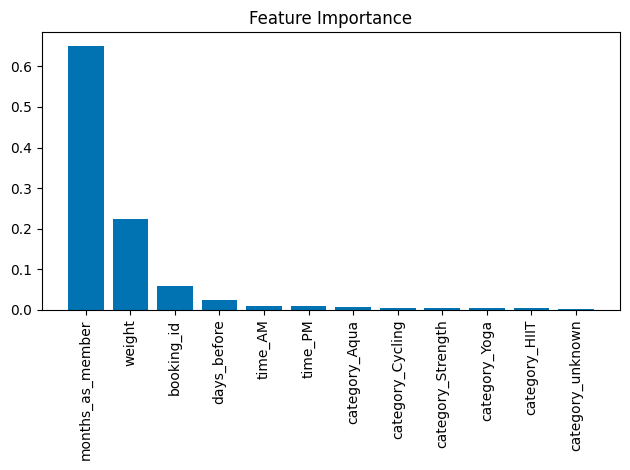

In [29]:
fimportance = best_rf_model_result.feature_importances_
sorted_indices = np.argsort(fimportance)[::-1]

plt.title('Feature Importance')
plt.bar(range(Xfulltrain.shape[1]), fimportance[sorted_indices], align='center')
plt.xticks(range(Xfulltrain.shape[1]), Xfulltrain.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

We can see that more than 80% of the feature_importance_ comes from two variables - months_as_member (a relationship we visualized earlier) and the weight of the member. Let's see if we can gain a more flexible and predictive model by trimming out excess variables.

In [30]:
#Create a trim dataframe for new X:
gzXtrim = gzdf[['months_as_member', 'weight']]
#Create a new train/test split:
Xtrimtrain, Xtrimtest, y_train, y_test = train_test_split(gzXtrim, gzY, test_size=0.33, random_state=123)

In [31]:
logregtrim = LogisticRegression()
logregtrimresult = logregtrim.fit(Xtrimtrain, y_train)
y_trimpred = logregtrimresult.predict(Xtrimtest)

print("Test Set Accuracy: ", accuracy_score(y_test, y_trimpred))
print(confusion_matrix(y_test, y_trimpred))
print("Precision:", precision_score(y_test, y_trimpred))
print("Recall:",recall_score(y_test, y_trimpred))

Test Set Accuracy:  0.7717171717171717
[[315  23]
 [ 90  67]]
Precision: 0.7444444444444445
Recall: 0.4267515923566879


We actually improve our accuracy score a bit and we see a handful of more correct predicted absences and attendees compared to the baseline logistic regression model. It seems the degrees of freedom we lost was not worth the tradeoff in predictive power and may have led to some overfitting. We correctly predicted 3 more absences and only missed 1 more attendee. This yielded a 0.4% increase to accuracy score, a precision score increase of 1.5% (percentage of absences correctly guessed) and a loss in recall score of 0.7% (percentage of attendees correctly guessed). Let's see if we can tune this model to perform any better:

In [32]:
# Instantiate GridSearchCV with the required parameters
trim_grid_model = GridSearchCV(estimator=logregtrim, param_grid=param_gridlog, cv=5)

# Fit grid_model to the data
trim_grid_model_result = grid_model.fit(Xtrimtrain, y_train)

# Summarize results
best_trim_score, best_trim_params = trim_grid_model_result.best_score_, trim_grid_model_result.best_params_
print("Best: %f using %s" % (best_trim_score, best_trim_params))

# Extract the best model and evaluate it on the test set
trim_best_model = trim_grid_model_result.best_estimator_
trim_best_model_result = trim_best_model.fit(Xtrimtrain, y_train)
y_gscv_trim_log_pred = trim_best_model_result.predict(Xtrimtest)

print("Test Set Accuracy: ", accuracy_score(y_test, y_gscv_trim_log_pred))
print(confusion_matrix(y_test, y_gscv_trim_log_pred))
print("Precision:", precision_score(y_test, y_gscv_trim_log_pred))
print("Recall:",recall_score(y_test, y_gscv_trim_log_pred))

Best: 0.784080 using {'max_iter': 100, 'tol': 0.01}
Test Set Accuracy:  0.7717171717171717
[[315  23]
 [ 90  67]]
Precision: 0.7444444444444445
Recall: 0.4267515923566879


After tuning, the model performed identically to the baseline trimmed logistic regression model. Let's see if we get any improvements from our Randeom Forest model running on the trimmed dataset.

In [33]:
#Instantiate RandomForestClassifier
rftrim = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=.1, random_state=123)
#Fit the model
rftrimresult = rftrim.fit(Xtrimtrain, y_train)

In [34]:
#Run prediction and evaluate
y_trimrfpred = rftrimresult.predict(Xtrimtest)
print("Test set accuracy:", accuracy_score(y_test, y_trimrfpred))
print(confusion_matrix(y_test, y_trimrfpred))
print("Precision:", precision_score(y_test, y_trimrfpred))
print("Recall:",recall_score(y_test, y_trimrfpred))

Test set accuracy: 0.7717171717171717
[[307  31]
 [ 82  75]]
Precision: 0.7075471698113207
Recall: 0.47770700636942676


On the whole, this random forest has the same accuracy score as the trimmed Logistic Regression model. It is worse at predicting absences, but better at predicting attendees - yielding a precision score of only 70.7% (a loss of 3.7%), but a recall of 47.7% (an increase of 5.1%).

In [37]:
params_rf = { 'n_estimators': [50, 100, 200, 500],'max_features': ['auto', 'sqrt', 'log2'],'min_samples_split' : [.1,.12,.14,.16,.18,.2], 'criterion' :['gini', 'entropy']}
grid_trimrf = GridSearchCV(estimator=rftrim, param_grid=params_rf, cv= 5, refit=True)
grid_trimrf_result = grid_trimrf.fit(Xtrimtrain, y_train)

In [40]:
# Summarize results
best_rftrim_score, best_rftrim_params = grid_trimrf_result.best_score_, grid_trimrf_result.best_params_
print("Best: %f using %s" % (best_rftrim_score, best_rftrim_params))

# Extract the best model and evaluate it on the test set
best_rftrim_model = grid_trimrf_result.best_estimator_
best_rftrim_model_result = best_rftrim_model.fit(Xtrimtrain, y_train)
y_gscv_trim_rf_pred = best_rftrim_model_result.predict(Xtrimtest)
print("Test set accuracy: ", accuracy_score(y_test, y_gscv_trim_rf_pred))
print(confusion_matrix(y_test, y_gscv_trim_rf_pred))
print("Precision:", precision_score(y_test, y_gscv_trim_rf_pred))
print("Recall:",recall_score(y_test, y_gscv_trim_rf_pred))

Best: 0.785075 using {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 0.12, 'n_estimators': 500}
Test set accuracy:  0.7737373737373737
[[309  29]
 [ 83  74]]
Precision: 0.7184466019417476
Recall: 0.4713375796178344


After tuning, this random forest actually performs the best of every model we have tested. We have a total accuracy score of 77.4% (an increase of 0.2% over all of our trim models to this point). It is worse at predicting absences than the logistic regression model, but better than the base Random Forest Model, and better at predicting attendees than the logistic regression model (although it does miss 1 attendee compared to the base Random Forest Model) - yielding a precision score of only 71.8% and a recall of 47.1%.

# Summary, Conclusions, and Suggested Next Steps

In summary, we ultimately tested 6 models - 3 logistic regression models and 3 Random Forest Models. We chose to use a logistic regression for its S-shaped curve. The bottom part of the S captures an absence while the top of the S captures an attendee. After testing, we found that the best curve for a Logistic Regression model used only months_as_member and weight as predictors.

A Random Forest Classifer is a machine learning model that is ideal to handle binary classifications like this. The model takes all of the data and determines how variables weight whether or not someone will attend a class. Strictly speaking, a Grid Search Cross Validated Random Forest Classifier using only months_as_member and weight as predictors performed with the highest accuracy of any model we tested. It should be noted that using Grid Search Cross Validation is a bit slower and requires higher compute. This model may be more expensive to deploy at scale than the Logistic Regression model.

Summarizing the code comparisons and scoring of the models above, all of the models perform with similar degrees of accuracy, though there is variance in where that accuracy is allocated. The logistic regression models are better at predicting absences and would likely be of better use in classes with lower attendance where the attendance cap is not at risk of being exceeded. If [Redacted] has budget or computing constraints, a Logistic Regression model using only weight and months_as_member without Grid Search would likely be the easiest to deploy as well. Conversely, the Random Forest Classifier is better at predicting attendees and would be more appropriate as a more conservative guide for allowing overbooking. I would deploy this model for classes that are closer consistently closer to the attendance cap. If [Redacted] is comfortable with the computing requirements, a Grid Search Cross Validated Random Forest Classifier using only months_as_member and weight as predictors also provides the highest accuracy of any model.

Suggested follow up analysis and prediction would include time series analysis of class attendance by class category, day of the week, to identify trends and patterns in class size for specific class days, times, and categories. I would also be curious to look into predictors of what produces longevity for [Redacted]'s members and why members do not tend to retain much longer than a year or two. This could be a way to grow [Redacted]'s business, build a more engaged community (as members with higher retention are more likely to attend the classes they book), and overall provide more revenue.